### Data Preparation  for LSTM
__project__: pedestrian trajecory prediction based on head orientation, previous trajectory and distance to cars

In [1]:
import pandas as pd
import numpy as np
from math import ceil
import time
import glob,os
import matplotlib.pyplot as plt
import pickle
import pdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import random

Using TensorFlow backend.


### Step 1: Data preprocess:
- convert to trajectory
- remove outliers
- normalize

In [3]:
# load data
with open('/home/arash/ProjectVR/cleaneddata/ALLDATA', 'rb') as f:
    ALLDATA = pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/experiments', 'rb') as f:
    experiments = pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/DesignID', 'rb') as f:
    DesignID = pickle.load(f)
   

#removing error data
ALLDATAfortraj=ALLDATA.loc[-ALLDATA['starttime'].isin(['Err1','Err2','Err3','Err4','Err5'])]

#only observable columns by AV are selected
ALLDATAfortraj=ALLDATAfortraj[['File','Scenario','Speed Limit', 'Lane Width', 
                               'Mean Arrival Rate', 'Snowy','One way', 'two way',
                               'Two way with median', 'Night','starttime']] 


ALLDATAfortraj=pd.get_dummies(data=ALLDATAfortraj,columns=['Speed Limit', 'Lane Width', 
                               'Mean Arrival Rate'])

# limit trajectory records to a time frame starting from 1 sec before cross to the end.
trajectory=[]
for n in range(len(experiments)):    
    if len(ALLDATAfortraj[ALLDATAfortraj['File']==experiments[n]['filename'][0]]['starttime'])>0:
        df=experiments[n][experiments[n]['timeelaspsed'].astype(float)>
                          (float(ALLDATAfortraj[ALLDATAfortraj['File']==
                                                experiments[n]['filename'][0]]['starttime'])-1)]
        df=df.drop(columns=['timehr','timemin','timesec',])
        trajectory.append(df)

# build time series data from pedestrian movements
Time=[]
userXtraj=[]
userYtraj=[]
usero1traj=[]
usero2traj=[]
usero3traj=[]
userdisttraj=[]
useraux=[]

for i in range(len(trajectory)):
    # 650 threshold is the approximate x coordinate for the middle of the road, 
    #user trajectory in the end of experiment are removed
    trajectory[i] = trajectory[i][trajectory[i]['x'].astype(float)>650]
    trajectory[i].reset_index(drop=True ,inplace = True)
    users = trajectory[i][trajectory[i]['status']=='u ']
    if len(users)>0:
        #check if the scenario is one road
        File = trajectory[i].iloc[0,-1]
        Scenario = int(ALLDATAfortraj[ALLDATAfortraj['File']==File]['Scenario'])
        oneroad=int(DesignID[DesignID['Card ID']== Scenario]['Road Type_One way'])
        
        tarr = users['timeelaspsed'].values.astype(float)
        tarr = tarr - tarr[0] #shift start to time zero
        xarr = users['x'].values.astype(float)
        yarr = users['y'].values.astype(float)
 
        #head orientation coordinates:
        headarr1 = users['o1'].values.astype(float)  
        headarr2 = users['o2'].values.astype(float)
        headarr3 = users['o3'].values.astype(float)    
        
        
        
        aux= ALLDATAfortraj[ALLDATAfortraj['File'] == File][   #get aux info 
                ['Snowy','Night', 'One way', 'two way', 'Two way with median',
                 'Speed Limit_30.0', 'Speed Limit_40.0', 'Speed Limit_50.0',
                 'Lane Width_2.5', 'Lane Width_2.75', 'Lane Width_3.0',
                 'Mean Arrival Rate_530.0', 'Mean Arrival Rate_750.0',
                 'Mean Arrival Rate_1100.0']].values
        aux=aux.reshape(aux.shape[1],)          #reshape to (14,)  14: number of aux categories
        aux =aux.astype(float) 

        
        pedindex = users.index
        #fixing the last record of ped:
        lastrec = trajectory[i].iloc[pedindex[-1]]['timeelaspsed']
        rest = trajectory[i][trajectory[i]['timeelaspsed']>lastrec]
        if len(rest)>0:
            lastped = trajectory[i][trajectory[i]['timeelaspsed']>lastrec].index[0]
            pedindex = np.append(pedindex,lastped) 
        else:
            pedindex = np.append(pedindex,pedindex[-1]+1)
       
        dist=[]
        for index, item in enumerate(pedindex):      #distance at every moment
            if index>0:
                bwped=trajectory[i].iloc[pedindex[index-1]:
                                         pedindex[index],:]  #data for a single frame
                if len(bwped[bwped['status'].str.contains('L',na=False)].index)==0:   
                    #if no cars on left lane at the moment
                    distance=100
                else:            
                    if oneroad==0:
                        if len((bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') &
                                      (bwped['y'].astype(float)> bwped.iloc[0,1])]['y']))==0:     
                            #check if any car that has not passed exists  
                            #1st cond: car on left lane, 2nd: not a user data, 3rd: car has not passed ped yet
                            #only 3rd differs for oneway and two-way roads
                            distance=100
                        else:
                            distance=min(bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') &
                                               (bwped['y'].astype(float)> \
                                                bwped.iloc[0,1])]['y']) - bwped.iloc[0,1] 
                    else:   #one-way roads
                        if len((bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') &
                                      (bwped['y'].astype(float)< bwped.iloc[0,1])]['y']))==0:     
                            #check if any car that has not passed exists  
                            #1st cond: car in left lane, 2nd not a user data, 3rd: car has not passed ped yet
                            #differs for oneway and two-way roads
                            distance = 100
                        else:
                            distance = bwped.iloc[0,1] - max(bwped[(bwped['x'].astype(float)>650)
                                      & (bwped['status'] !='u ') & (bwped['y'].astype(float)< 
                                                                    bwped.iloc[0,1])]['y']) 
                dist.append(distance)

        Time.append(tarr)
        userXtraj.append(xarr)
        userYtraj.append(yarr)
        usero1traj.append(headarr1)
        usero2traj.append(headarr2)
        usero3traj.append(headarr3)
        userdisttraj.append(dist)
        useraux.append(aux)

In [4]:
#check for ouliers
dur=[]
for i in range(len(Time)):
    t = Time[i][-1]
    dur.append(t)

dur=pd.DataFrame(dur,columns=['duration'])

dur.describe()

,duration
count,3418.000000
mean,5.022575
std,5.905826
min,0.000000
25%,2.799820
50%,3.457180
75%,4.643320
max,105.279570


(array([5.41e+02, 2.24e+03, 2.57e+02, 1.21e+02, 7.40e+01, 5.80e+01,
        2.90e+01, 2.50e+01, 1.60e+01, 8.00e+00, 1.20e+01, 1.00e+01,
        5.00e+00, 1.00e+00, 1.00e+00, 5.00e+00, 2.00e+00, 2.00e+00,
        1.00e+00, 2.00e+00, 2.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00]),
 array([  0.        ,   2.63198925,   5.2639785 ,   7.89596775,
         10.527957  ,  13.15994625,  15.7919355 ,  18.42392475,
         21.055914  ,  23.68790325,  26.3198925 ,  28.95188175,
         31.583871  ,  34.21586025,  36.8478495 ,  39.47983875,
         42.111828  ,  44.74381725,  47.3758065 ,  50.00779575,
         52.639785  ,  55.27177425,  57.9037635 ,  60.53575275,
         63.167742  ,  65.79973125,  68.4317205 ,  71.06370975,
         73.695699  ,  76.32768825,  78.9596775 ,  81.59166675,
         84.223656  ,  86.8556

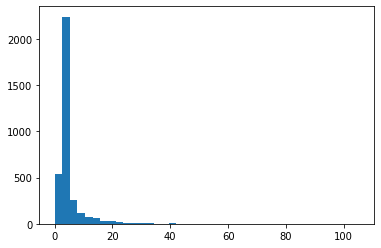

In [5]:
plt.hist(dur.iloc[:,0],bins=40)

In [6]:
#indices of experiments when it takes more than ~15 seconds  to cross. 142 rows out of total 3424 removed
out=dur[dur['duration']>15].index

for i in sorted(out,reverse=True):      #reverse is true to make sure indices does not change after removing
    del userXtraj[i]
    del userYtraj[i]
    del usero1traj[i]
    del usero2traj[i]
    del usero3traj[i]
    del userdisttraj[i]
    del useraux[i]
    del Time[i]

In [7]:
# Data Normalization
# normalization using min max method: (keras min max not used due to format difference)
#o1,o2,o3: are already bw 0 and 1
    
maxX = max(map(max, userXtraj))
minX = min(map(min, userXtraj))

maxY = max(map(max, userYtraj))
minY = min(map(min, userYtraj))

maxdist=100
mindist=[]
for i in range(len(userdisttraj)):  #findimg max and min of each feature
    if len(userdisttraj[i])>0:
        mindist.append(min(userdisttraj[i]))

mindist = min(mindist)

Xscaled=[]
Yscaled=[]
distscaled=[]
for i in range(len(userXtraj)):
    Xscaled.append((userXtraj[i]-minX)/(maxX-minX))
    Yscaled.append((userYtraj[i]-minY)/(maxY-minY))
    distscaled.append((userdisttraj[i]-mindist)/(maxdist-mindist))
    

Xscaled=np.array(Xscaled)
Yscaled=np.array(Yscaled)
distscaled=np.array(distscaled)
#inverse normalization function using min max method
# def invNORM (ypred,y,maxXY,minXY):    # function to calculate RMSE based on inverse normalized
#     yinv = np.zeros(y.shape)
#     ypredinv=np.zeros(ypred.shape)
#     for i in range(len(y)):
#         pos = sum (n>=0 for n in y[i])                #position of the last actual value on y, not padded
#         yinv[i][:pos]= y[i][:pos] * (maxXY-minXY) + minXY
#         ypredinv[i][:pos] = ypred[i][:pos]* (maxXY-minXY) + minXY
    
#     return ypredinv, yinv

### Type 1 Data: Create sequential data based on distance:
 __Input__: sequence data in the first n% of the road width + aux <br>
 __Output__: coordiantes in the rest (1-n)% of the road width

In [46]:
def LengthSeq(userXtraj,userYtraj,usero1traj,
              usero2traj,usero3traj, userdisttraj,
              useraux, inputportion):
    X, Xoutput, Y, Youtput, Aux,\
    o1, o1output, o2, o2output,\
    o3, o3output, dist, distoutput =\
    list(), list(), list(), list(),\
    list(), list(), list(), list(),\
    list(), list(), list(), list(), list()
    for i in range(len(userXtraj)):
        # find the end of this pattern
        xdistancecovered = userXtraj[i][0] - userXtraj[i][-1] #total distance covered by user
        if xdistancecovered>0:
            xinput = xdistancecovered * inputportion     #distance that is used as input to the model                   
            breakpoint = userXtraj[i][0] - xinput       #x is descending
            n_steps = len([x for x in userXtraj[i] if x>breakpoint])

            # gather input and output parts of the pattern
            seq_x, seq_Xout = userXtraj[i][0:n_steps], userXtraj[i][n_steps:]
            seq_y, seq_Yout = userYtraj[i][0:n_steps], userYtraj[i][n_steps:]
            seq_o1, seq_o1out = usero1traj[i][0:n_steps], usero1traj[i][n_steps:]
            seq_o2, seq_o2out= usero2traj[i][0:n_steps], usero2traj[i][n_steps:]
            seq_o3, seq_o3out= usero3traj[i][0:n_steps], usero3traj[i][n_steps:]
            seq_dist, seq_distout = userdisttraj[i][0:n_steps], userdisttraj[i][n_steps:] 

            X.append(seq_x)
            Xoutput.append(seq_Xout)

            Y.append(seq_y)
            Youtput.append(seq_Yout)

            o1.append(seq_o1)
            o1output.append(seq_o1out)

            o2.append(seq_o2)
            o2output.append(seq_o2out)

            o3.append(seq_o3)
            o3output.append(seq_o3out)

            dist.append(seq_dist)
            distoutput.append(seq_distout)
            
            Aux.append(useraux[i])
        
    return np.array(X),np.array(Xoutput),np.array(Y),\
            np.array(Youtput),np.array(o1),\
            np.array(o1output),np.array(o2),\
            np.array(o2output),np.array(o3),\
            np.array(o3output),np.array(dist),\
            np.array(distoutput), np.array(Aux)


In [53]:
inputportion = 0.5
X, Xoutput,\
Y, Youtput,\
o1, o1output,\
o2, o2output,\
o3, o3output,\
dist , distoutput, Aux = LengthSeq(Xscaled, Yscaled, 
                                   usero1traj, usero2traj,
                                   usero3traj, distscaled,
                                   useraux, inputportion)

# padding sequences to have same length by adding negative values:
X = pad_sequences(X, dtype='float32',value=-0.01)   
Y = pad_sequences(Y, padding='post',dtype='float32',value=-0.01)
o1 = pad_sequences(o1,dtype='float32',value=-0.01)
o2 = pad_sequences(o2,dtype='float32',value=-0.01)
o3 = pad_sequences(o3,dtype='float32',value=-0.01)
dist = pad_sequences(dist,dtype='float32',value=-0.01)
Xoutput = pad_sequences(Xoutput, dtype='float32',value=-0.01)   
Youtput = pad_sequences(Youtput, padding='post',dtype='float32',value=-0.01)
o1output = pad_sequences(o1output,dtype='float32',value=-0.01)
o2output = pad_sequences(o2output,dtype='float32',value=-0.01)
o3output = pad_sequences(o3output,dtype='float32',value=-0.01)
distoutput = pad_sequences(distoutput,dtype='float32',value=-0.01)

### Type 2 Data: Create sequential data based on time:
 __Input__: sequence data in the first t1 seconds of cross + aux <br>
 __Output__: coordiantes in the next t2 seconds of cross

In [56]:
def TimeSeq(userXtraj,userYtraj, Time,useraux,
                usero1traj,usero2traj,usero3traj,
                userdisttraj, Tinput,Toutput):
    X, Xoutput, Y, Youtput, Aux,\
    o1, o1output, o2, o2output,\
    o3, o3output, dist, distoutput =\
    list(), list(), list(), list(),\
    list(), list(), list(), list(),\
    list(), list(), list(), list(),list()\
    
    TinpInd =  int(Tinput/0.1)
    ToutInd =  int(Toutput/0.1)
    for i in range(len(userXtraj)):
        start = 0
        inp = start + TinpInd
        out = inp + ToutInd
        
        while out < (len(userXtraj[i])+1):
            # gather input and output parts of the pattern
            seq_x, seq_Xout = userXtraj[i][start:inp], userXtraj[i][inp:out]
            seq_y, seq_Yout = userYtraj[i][start:inp], userYtraj[i][inp:out]
            seq_o1, seq_o1out = usero1traj[i][start:inp], usero1traj[i][inp:out]
            seq_o2, seq_o2out= usero2traj[i][start:inp], usero2traj[i][inp:out]
            seq_o3, seq_o3out= usero3traj[i][start:inp], usero3traj[i][inp:out]
            seq_dist, seq_distout = userdisttraj[i][start:inp], userdisttraj[i][inp:out] 

            X.append(seq_x)
            Xoutput.append(seq_Xout)
            
            Y.append(seq_y)
            Youtput.append(seq_Yout)
            
            o1.append(seq_o1)
            o1output.append(seq_o1out)
            
            o2.append(seq_o2)
            o2output.append(seq_o2out)
            
            o3.append(seq_o3)
            o3output.append(seq_o3out)
            
            dist.append(seq_dist)
            distoutput.append(seq_distout)
            
            Aux.append(useraux[i])
            
            start += 1
            inp = start + TinpInd
            out = inp + ToutInd
        
    return np.array(X),np.array(Xoutput),np.array(Y),\
        np.array(Youtput),np.array(o1),\
        np.array(o1output),np.array(o2),\
        np.array(o2output),np.array(o3),\
        np.array(o3output),np.array(dist),\
        np.array(distoutput), np.array(Aux)

In [60]:
Tinput = 0.5
Toutput = 1
X, Xoutput,\
Y, Youtput,\
o1, o1output,\
o2, o2output,\
o3, o3output,\
dist,distoutput, Aux = TimeSeq(Xscaled, Yscaled,
                                   Time, useraux, 
                                   usero1traj, usero2traj,
                                   usero3traj, distscaled,
                                   Tinput,Toutput)

###  Final Step: 
- Merging prepared data to create input and output data
- Seperate test and train set
- Save data to file

In [61]:
inputseq = []
outputseq = []
for i in range(len(X)):
    mrg_input=np.transpose(np.vstack((X[i],Y[i],o1[i],o2[i],o3[i],dist[i])))
    
    mrg_output=np.transpose(np.vstack((Xoutput[i],Youtput[i],o1output[i],\
                                       o2output[i],o3output[i],distoutput[i])))
    
    inputseq.append(mrg_input)
    outputseq.append(mrg_output)

inputseq=np.array(inputseq)
outputseq=np.array(outputseq)
inputaux = Aux

### Seperating test set before any modeling

# seperate validation data and test set
tst=0.2                 #% if test data
#val=0.2                 #% if valid data       
tstsize = int(np.floor(len(X) * tst))
#valsize = int(np.floor(len(X) * val))

tstlabel = random.sample(range(0, (len(X)-1)), len(range(tstsize)))

inputseqTEST = inputseq[tstlabel]
inputauxTEST = inputaux[tstlabel]
outTEST = outputseq[tstlabel]

trnlabel=[i for i in range(inputseq.shape[0]) if i not in tstlabel]

inputseqtrain = inputseq[trnlabel]          #Excluding test set
inputauxtrain = inputaux[trnlabel]
outtrain = outputseq[trnlabel]

In [62]:
folder = '/home/arash/ProjectVR/cleaneddata/seperateddata/'
dtype = '_TW_0.5_1'   
#TW_i_o for time seq, i sec input, o sec output length 
#LW_n for length seq, n/10 input proportion

with open(f'{folder}inputseqTrain{dtype}', 'wb') as f:
     pickle.dump(inputseqtrain, f)

with open(f'{folder}inputauxTrain{dtype}', 'wb') as f:
     pickle.dump(inputauxtrain, f)

with open(f'{folder}outTrain{dtype}', 'wb') as f:
    pickle.dump(outtrain, f)

with open(f'{folder}inputseqTest{dtype}', 'wb') as f:
     pickle.dump(inputseqTEST, f)

with open(f'{folder}inputauxTest{dtype}', 'wb') as f:
     pickle.dump(inputauxTEST, f)

with open(f'{folder}outTest{dtype}', 'wb') as f:
     pickle.dump(outTEST, f)